In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from sklearn.cluster import KMeans
from importlib import reload

import utils
import hhclustering as hc
reload(utils)
reload(hc)

<module 'hhclustering' from 'C:\\Users\\jungyoung\\Desktop\\Project\\hh_neuralnet\\three_pop_mpi\\clustering\\hhclustering.py'>

In [2]:
# load data
with open("./data/purified_data.pkl", "rb") as fp:
    buf = pkl.load(fp)
data = buf["data"]
row_labels = buf["row_labels"]
row_names = buf["row_names"]
col_names = buf["col_names"]

In [7]:
# Clustering
utils.set_seed(500)

num_clusters = np.arange(2, 15)

km_scores = []
s_scores = []
s_vals = []
km_obj_set = []

for nc in num_clusters:
    km_obj = KMeans(n_clusters=nc, init="k-means++")
    km_obj.fit(data.T)
    labels = km_obj.predict(data.T)
    sval, scoeff = hc.get_silhouette_scores(data, labels)

    km_scores.append(km_obj.inertia_)
    s_scores.append(scoeff)
    s_vals.append(sval)
    km_obj_set.append(km_obj)

save to ./data\./Kmeans_compare_2023624.png


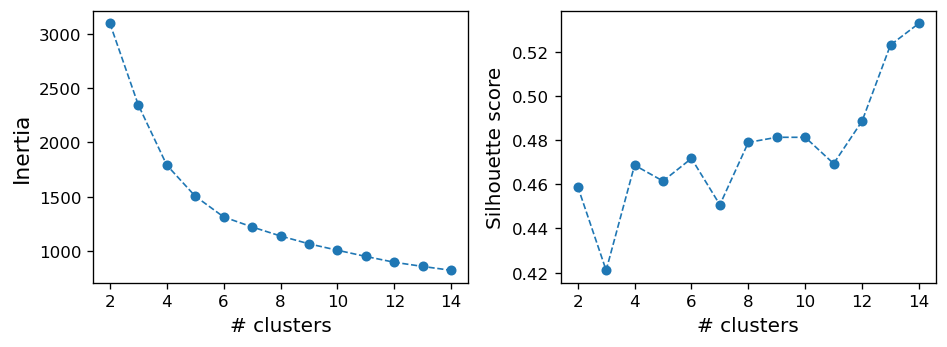

In [8]:
fig, axs = plt.subplots(1, 2, dpi=120, figsize=(8, 3))
plt.axes(axs[0])
plt.plot(num_clusters, km_scores, '.--', ms=10, lw=1)
plt.ylabel("Inertia", fontsize=13)
plt.xticks(num_clusters[::2])
plt.xlabel("# clusters", fontsize=12)

plt.axes(axs[1])
plt.plot(num_clusters, s_scores, '.--', ms=10, lw=1)
plt.ylabel("Silhouette score", fontsize=12)
plt.xticks(num_clusters[::2])
plt.xlabel("# clusters", fontsize=12)

plt.tight_layout()
utils.save_fig("./Kmeans_compare")
plt.show()

In [10]:
with open("./data/clustering_result.pkl", "wb") as fp:
    pkl.dump({
        "km_obj": km_obj_set,
        "s_vals": s_vals,
        "s_scores": s_scores,
        "num_clusters": num_clusters},
        fp)

## Denoise clustering 

In [3]:
with open("./data/clustering_result.pkl", "rb") as fp:
    tmp = pkl.load(fp)

km_obj_set = tmp["km_obj"]
s_vals = tmp["s_vals"]
s_scores = tmp["s_scores"]
num_clusters = tmp["num_clusters"]

num_clusters: 11


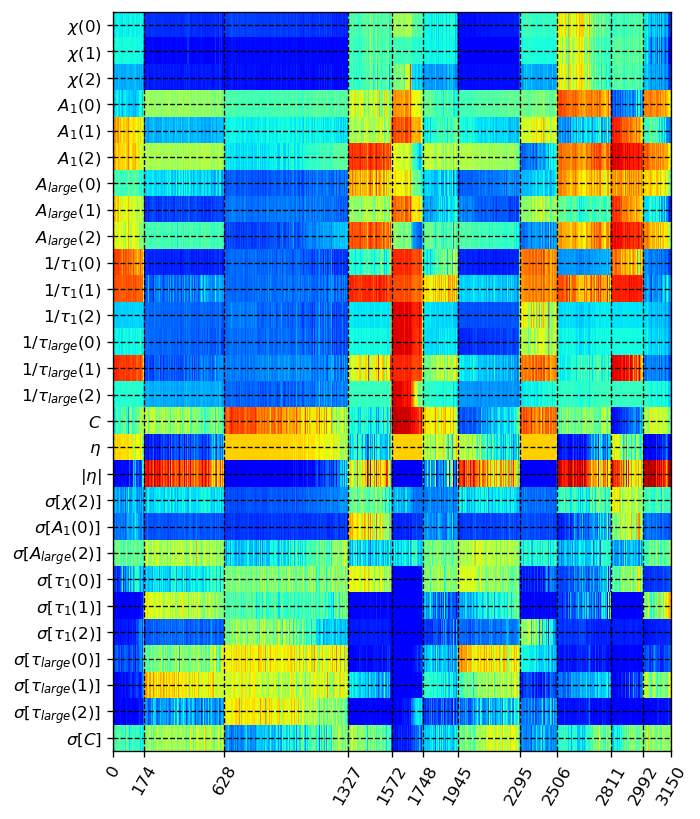

In [5]:
nc = 9
num_c = num_clusters[nc]

print("num_clusters: %d"%(num_c))

cluster_id = km_obj_set[nc].predict(data.T)
sval = s_vals[nc]
scoeff = s_scores[nc]

reordered_data, id_sort, bds = hc.reorder_data(data, cluster_id, sval)
sdata = hc.hsmooth(reordered_data)

plt.figure(figsize=(6, 8), dpi=120)
plt.imshow(sdata, aspect='auto', cmap="jet", interpolation="none")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(len(row_labels)), labels=row_labels)
plt.grid(True, lw=0.8, c='k', linestyle='--')
# utils.save_fig("filtered_cluster_nc=%d"%(num_clusters[nc]))

plt.show()

save to ./fig\denoise_flow_2023626.png


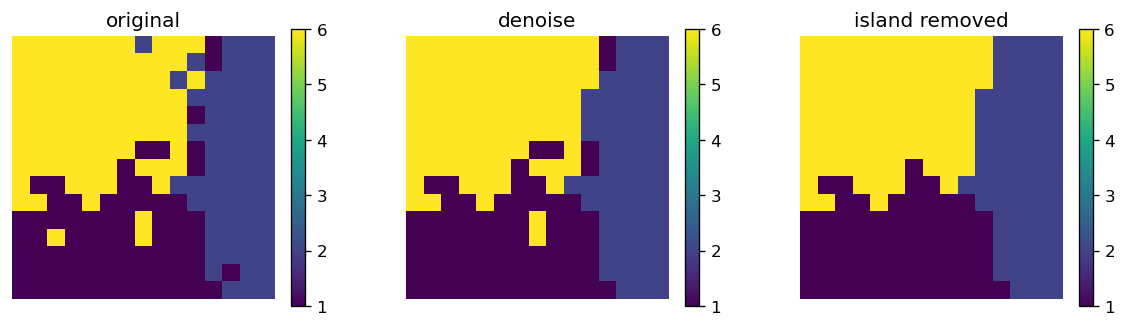

In [11]:
tag = "nr0np1"
im0, _ = hc.construct_square_image(tag, cluster_id, col_names)
im1 = hc.denoise_square_cluster(im0)
im2 = hc.remove_cluster_island(im1, nth=3)

plt.figure(figsize=(12, 3), dpi=120)
plt.subplot(131)
plt.imshow(im0)
plt.title("original")
plt.axis("off")
plt.colorbar()

plt.subplot(132)
plt.imshow(im1)
plt.title("denoise")
plt.axis("off")
plt.colorbar()

plt.subplot(133)
plt.imshow(im2)
plt.title("island removed")
plt.axis("off")
plt.colorbar()

utils.save_fig("denoise_flow")

plt.show()